# **Final report Unet implementation Pytorch**



B074020037 陳柏豪
B084020008 李亭熙

In [ ]:
!pip install -q albumentations==0.4.6

     |████████████████████████████████| 117 kB 5.3 MB/s 
     |████████████████████████████████| 948 kB 40.9 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os , glob
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm

import torch
from torch import Tensor
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from keras.preprocessing import image
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset , DataLoader
from torchvision import transforms , utils , datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 資料連結
train  [LINK of Google Drive](https://drive.google.com/file/d/1avuduJLdODXRzXUhy-L3bDwWZe-jqm2T/view?usp=sharing)  
train_mask  [LINK of Google Drive](https://drive.google.com/file/d/1OcM40KDBtkiysSqoLnZvSXmsAE6pPjqW/view?usp=sharing)  
train_masks.csv [LINK of Google Drive](https://drive.google.com/file/d/1P0NgWbtP4VHBmxzBaXPSCyC4yTCQHocd/view?usp=sharing)  

In [ ]:
!unzip -qq ./drive/My\ Drive/Carvana/train.zip
#!unzip -qq ./drive/My\ Drive/Carvana/train_hq.zip
!unzip -qq ./drive/My\ Drive/Carvana/train_masks.csv.zip
!unzip -qq ./drive/My\ Drive/Carvana/train_masks.zip

In [ ]:
#取得資料
print('Train Size : ',len(glob.glob('./train/*')))
print('Mask Size : ',len(glob.glob('./train_masks/*')))
data = pd.read_csv('train_masks.csv')
data

Train Size :  5088
Mask Size :  5088


,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...
...,...,...
5083,fff9b3a5373f_12.jpg,386005 13 387915 27 389829 34 391744 38 393660...
5084,fff9b3a5373f_13.jpg,393674 6 395585 19 397498 26 399412 32 401327 ...
5085,fff9b3a5373f_14.jpg,401397 9 403309 19 405223 26 405389 145 407138...
5086,fff9b3a5373f_15.jpg,407257 6 407393 89 409171 12 409263 179 411086...


查看dataset

(1280, 1918, 3)


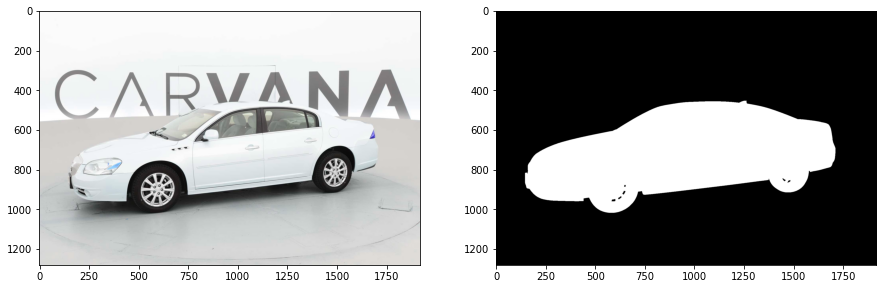

In [ ]:
fig=plt.figure(figsize=(15, 15))
img=cv2.imread('./train/d46244bc42ed_04.jpg')
mask=Image.open('./train_masks/d46244bc42ed_04_mask.gif') #Image from PIL 
print(img.shape)
files=[img,mask]
for i in range(len(files)):
    plt.subplot(1, 2 , i+1)
    plt.imshow(files[i])

#處理Carvana Dataset

In [ ]:
class CaravanDataset(Dataset) :
    
    def __init__(self,root_dir,img_list,transform_img=None,transform_m=None) :
        
        self.root_dir = root_dir
        self.image_list = img_list
        self.transform_img = transform_img
        self.transform_m = transform_m
    
    def __len__(self) :
        return len(self.image_list)
    
    def __getitem__(self,idx) :
        
        img_name = self.image_list[idx]
        img_path = self.root_dir +'/'+ str(img_name)
        
        mask_name = img_name.split('.')[0] + '_mask.gif'
        mask_path = self.root_dir +'_masks/'+ str(mask_name)
        
        img = cv2.imread(img_path)
        mask = Image.open(mask_path)    #Object of PIL 
        mask = image.img_to_array(mask)
        

        
        if self.transform_img :
            img = self.transform_img(image=img)['image']
            
        if self.transform_m :
            mask = self.transform_m(image=mask)['image']
        
        return img,mask
    


#Transform

In [ ]:
#Transformations to be performed on the image and mask
transform_img = A.Compose([
    A.Resize(600,600),
    A.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]),
    ToTensorV2()])

transform_mask = A.Compose([
    A.Resize(600,600),ToTensorV2()])

images = (pd.read_csv('./train_masks.csv')['img'])
dataset = CaravanDataset('./train',images,transform_img,transform_mask)

#分成訓練集及測試集

In [ ]:
mini_train_size = int(len(images)*0.2)
mini_val_size = len(images)-mini_train_size
mini_train_set, mini_val_set = torch.utils.data.random_split(dataset, [mini_train_size, mini_val_size]) # We sample 10% of the images as a validation dataset
print(mini_train_size,mini_val_size)

1017 4071


In [ ]:
train_size = int(len(images)*0.95)
val_size = len(images)-train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size]) # We sample 10% of the images as a validation dataset
train_set = mini_train_set

In [ ]:
# train_size = int(len(images)*0.3)
# val_size = len(images)-train_size
# train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size]) # We sample 10% of the images as a validation dataset
# print(train_size,val_size)



train_dataloader = torch.utils.data.DataLoader(train_set,
                                          batch_size=4,
                                          shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(val_set,
                                          batch_size=4,
                                          shuffle=True)

#Unet model

In [ ]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
        
        self.double_conv = nn.Sequential(
            
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),#計算穩定性
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

def dice_calc(gt,pred) :
    pred = torch.sigmoid(pred)
    pred = ((pred) >= .5).float()
    dice_score = (2 * (pred * gt).sum()) / ((pred + gt).sum() + 1e-8)
    
    return dice_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = UNet(n_channels=3, n_classes=1, bilinear=True)
net.to(device=device)
#optimizer = torch.optim.SGD(net.parameters(),lr=0.0001, momentum=0.9)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = optim.RMSprop(net.parameters(), lr=0.0001, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

if net.n_classes > 1:
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.BCEWithLogitsLoss()

#Train

In [ ]:
def train(epoch,epochs,tloader) :
    net.train()
    
    tloader.set_description(f'EPOCH {epoch}')
    epoch_loss = 0
    dice_score = 0
    num_correct = 0    
    
    for images , masks in tloader :
 
        optimizer.zero_grad()
        images = images.to(device, dtype=torch.float32)
        masks  = masks.to(device, dtype=torch.float32)
        mask_pred = net(images)

        loss = criterion(mask_pred,masks)
        epoch_loss += loss.item() 
        loss.backward()
        optimizer.step()
    
        running_DS = dice_calc(masks,mask_pred)
        dice_score += running_DS
                
        tloader.set_postfix(loss=loss.item(),accuracy=(running_DS.item()))
    print(' Train Dice Score Epoch : ',dice_score/len(train_dataloader))
def validation(vloader) :
    net.eval()
    vloader.set_description('Validation')
    
    n_val = len(valid_dataloader)
    total = 0
    dice_score = 0
    num_correct = 0
    
    with torch.no_grad():
        for images ,masks in vloader :

            images = images.to(device)
            masks  = masks.to(device)
                
            mask_pred = net(images)
            
            loss = criterion(mask_pred,masks)
            
            running_DS = dice_calc(masks,mask_pred)
            dice_score += running_DS
            
            vloader.set_postfix(loss=loss.item(),accuracy=(running_DS.item()))
        
    print('Validation Dice Score Epoch : ',dice_score/len(valid_dataloader))

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()
epochs = 2

for epoch in range(epochs) :
    print(epoch+1,'/',epochs)
    with tqdm(train_dataloader,unit='batch') as tloader : 
        train(epoch,epochs,tloader)
    
    with tqdm(valid_dataloader,unit='batch') as vloader:
        validation(vloader)

1 / 2


EPOCH 0: 100%|██████████| 255/255 [22:35<00:00,  5.32s/batch, accuracy=0.959, loss=0.0464]


 Train Dice Score Epoch :  tensor(0.9133, device='cuda:0')


Validation: 100%|██████████| 64/64 [01:58<00:00,  1.84s/batch, accuracy=0.96, loss=0.055]


Validation Dice Score Epoch :  tensor(0.9632, device='cuda:0')
2 / 2


EPOCH 1: 100%|██████████| 255/255 [22:35<00:00,  5.31s/batch, accuracy=0.961, loss=0.0628]


 Train Dice Score Epoch :  tensor(0.9643, device='cuda:0')


Validation: 100%|██████████| 64/64 [01:57<00:00,  1.84s/batch, accuracy=0.979, loss=0.0211]

Validation Dice Score Epoch :  tensor(0.9559, device='cuda:0')


In [ ]:
torch.save(net.state_dict(), "net_model.pt")

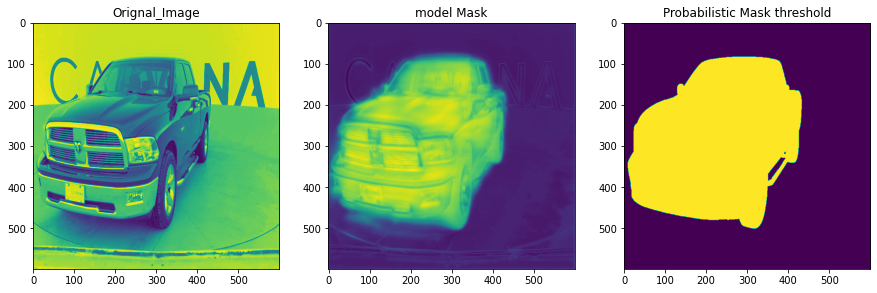

In [ ]:
with torch.no_grad():
    for images ,masks in valid_dataloader :
        images = images.to(device)
        masks  = masks.to(device)

        orig_images = images.cpu().numpy()

        mask_pred = net(images)

        img = mask_pred.cpu().numpy()
        masks = masks.cpu().numpy()
        masks_2 = (masks > 0.5).astype(int)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 15))
        
        

        axes[0].imshow(orig_images[0][0])
        axes[0].set_title('Orignal_Image')
        
        axes[1].imshow(img[0][0])
        axes[1].set_title('model Mask')
        
        axes[2].imshow(masks_2[0][0])
        axes[2].set_title('Probabilistic Mask threshold')
        break